# Field-Level Inference on Synthetic Data

This notebook demonstrates the complete field-level inference pipeline:
1. Create a `FieldLevelModel` from configuration
2. Generate synthetic observations from truth parameters
3. Run MCMC inference to recover parameters
4. Analyze chains and compare to truth
5. Visualize results

This follows the approach from [benchmark-field-level](https://github.com/hsimonfroy/benchmark-field-level).

In [2]:
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np
import numpyro
from numpyro.infer import MCMC, NUTS

from desi_cmb_fli.model import FieldLevelModel, default_config

print(f"JAX version: {jax.__version__}")
print(f"NumPyro version: {numpyro.__version__}")
print(f"Default backend: {jax.default_backend()}")

/pscratch/sd/j/jhawla/envs/desi-cmb-fli/lib/python3.11/site-packages/jax_cosmo/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
ERROR:2025-10-31 07:39:55,731:jax._src.xla_bridge:473: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/pscratch/sd/j/jhawla/envs/desi-cmb-fli/lib/python3.11/site-packages/jax_plugins/xla_cuda12/__init__.py", line 201, in _version_check
    version = get_version()
              ^^^^^^^^^^^^^
RuntimeError: jaxlib/cuda/versions_helpers.cc:81: operation cusparseGetProperty(MAJOR_VERSION, &major) failed: The cuSPARSE library was not found.

The above exception was the direct cause of the following exception:



JAX version: 0.8.0
NumPyro version: 0.19.0
Default backend: cpu


## 1. Model Configuration

We'll use a small mesh for demonstration purposes.

In [ ]:
# Create configuration
config = default_config.copy()
config["mesh_shape"] = (8, 8, 8)
config["box_shape"] = (200.0, 200.0, 200.0)  # Mpc/h
config["evolution"] = "lpt"
config["lpt_order"] = 2
config["a_obs"] = 0.5  # Scale factor for observation
config["gxy_density"] = 0.001  # Galaxy number density [h³/Mpc³]

# Remove invalid keys that may be in default_config
config.pop("scale_factor", None)
config.pop("ng", None)

print("Configuration:")
for k, v in config.items():
    print(f"  {k}: {v}")

Configuration:
  mesh_shape: (16, 16, 16)
  box_shape: (200.0, 200.0, 200.0)
  a_obs: 0.5
  evolution: lpt
  nbody_steps: 5
  nbody_snapshots: None
  lpt_order: 2
  gxy_density: 0.001
  observable: field
  los: (0.0, 0.0, 1.0)
  poles: (0, 2, 4)
  precond: kaiser_dyn
  latents: {'Omega_m': {'group': 'cosmo', 'label': '{\\Omega}_m', 'loc': 0.3111, 'scale': 0.5, 'scale_fid': 0.02, 'low': 0.05, 'high': 1.0}, 'sigma8': {'group': 'cosmo', 'label': '{\\sigma}_8', 'loc': 0.8102, 'scale': 0.5, 'scale_fid': 0.02, 'low': 0.0, 'high': inf}, 'b1': {'group': 'bias', 'label': '{b}_1', 'loc': 1.0, 'scale': 0.5, 'scale_fid': 0.04}, 'b2': {'group': 'bias', 'label': '{b}_2', 'loc': 0.0, 'scale': 2.0, 'scale_fid': 0.02}, 'bs2': {'group': 'bias', 'label': '{b}_{s^2}', 'loc': 0.0, 'scale': 2.0, 'scale_fid': 0.08}, 'bn2': {'group': 'bias', 'label': '{b}_{\\nabla^2}', 'loc': 0.0, 'scale': 2.0, 'scale_fid': 0.2}, 'init_mesh': {'group': 'init', 'label': '{\\delta}_L'}}


In [6]:
# Create model
model = FieldLevelModel(**config)
print(model)

# CONFIG
{'a_obs': 0.5,
 'box_shape': array([200., 200., 200.]),
 'evolution': 'lpt',
 'gxy_density': 0.001,
 'latents': {'Omega_m': {'group': 'cosmo',
                         'high': 1.0,
                         'label': '{\\Omega}_m',
                         'loc': 0.3111,
                         'loc_fid': 0.3111,
                         'low': 0.05,
                         'scale': 0.5,
                         'scale_fid': 0.02},
             'b1': {'group': 'bias',
                    'label': '{b}_1',
                    'loc': 1.0,
                    'loc_fid': 1.0,
                    'scale': 0.5,
                    'scale_fid': 0.04},
             'b2': {'group': 'bias',
                    'label': '{b}_2',
                    'loc': 0.0,
                    'loc_fid': 0.0,
                    'scale': 2.0,
                    'scale_fid': 0.02},
             'bn2': {'group': 'bias',
                     'label': '{b}_{\\nabla^2}',
                     'loc': 0.0,
 

## 2. Generate Synthetic Data

We'll create a "truth" dataset by forward-simulating the model with known parameters.

In [7]:
# Truth parameters
truth_params = {
    "Omega_m": 0.3,
    "sigma8": 0.8,
    "b1": 1.0,
    "b2": 0.0,
    "bs2": 0.0,
    "bn2": 0.0,
}

print("Truth parameters:")
for k, v in truth_params.items():
    print(f"  {k}: {v}")

Truth parameters:
  Omega_m: 0.3
  sigma8: 0.8
  b1: 1.0
  b2: 0.0
  bs2: 0.0
  bn2: 0.0


In [8]:
# Generate truth data
seed = 42
rng = jr.key(seed)

truth = model.predict(samples=truth_params, hide_base=False, frombase=True, rng=rng)

obs_data = truth["obs"]
print(f"Observed field shape: {obs_data.shape}")
print(f"Mean N_obs: {jnp.mean(obs_data):.4f}")
print(f"Std: {jnp.std(obs_data):.4f}")

/pscratch/sd/j/jhawla/envs/desi-cmb-fli/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:125: UserWarning: Explicitly requested dtype int64 requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Observed field shape: (16, 16, 16)
Mean N_obs: 2.2168
Std: 3.3507


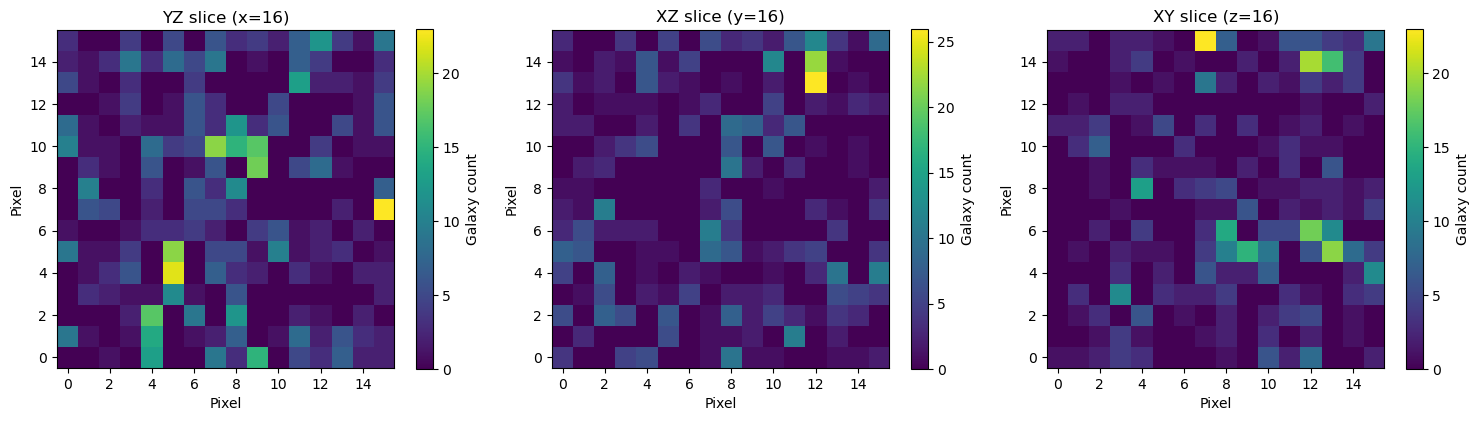

In [9]:
# Visualize observed field (slice through center)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

slices = [
    obs_data[16, :, :],
    obs_data[:, 16, :],
    obs_data[:, :, 16],
]
titles = ["YZ slice (x=16)", "XZ slice (y=16)", "XY slice (z=16)"]

for ax, data, title in zip(axes, slices, titles, strict=True):
    im = ax.imshow(data, origin="lower", cmap="viridis")
    ax.set_title(title)
    ax.set_xlabel("Pixel")
    ax.set_ylabel("Pixel")
    plt.colorbar(im, ax=ax, label="Galaxy count")

plt.tight_layout()
plt.show()

## 3. Run MCMC Inference

Now we'll use NUTS to infer the parameters from the observed data.

In [10]:
# Reset and condition model on observations
model.reset()
model.condition({"obs": obs_data})

In [11]:
# Initialize from Kaiser posterior
rng_init = jr.key(123)
init_params = model.kaiser_post(rng_init, obs_data, base=True)

print("Initialized parameters:")
for k, v in init_params.items():
    if k != "init_mesh":
        print(f"  {k}: {v}")

Initialized parameters:
  Omega_m: 0.3111
  sigma8: 0.8102
  b1: 1.0
  b2: 0.0
  bs2: 0.0
  bn2: 0.0


In [ ]:
# MCMC configuration
num_warmup = 50
num_samples = 50
num_chains = 1
target_accept_prob = 0.65

print("MCMC settings:")
print(f"  Warmup: {num_warmup}")
print(f"  Samples: {num_samples}")
print(f"  Chains: {num_chains}")
print(f"  Target accept prob: {target_accept_prob}")

MCMC settings:
  Warmup: 50
  Samples: 50
  Chains: 1
  Target accept prob: 0.65


In [13]:
# Run MCMC
rng_mcmc = jr.key(456)

nuts_kernel = NUTS(
    model.model,
    target_accept_prob=target_accept_prob,
    init_strategy=numpyro.infer.init_to_value(values=init_params),
)

mcmc = MCMC(
    nuts_kernel,
    num_warmup=num_warmup,
    num_samples=num_samples,
    num_chains=num_chains,
    progress_bar=False,
)

mcmc.run(rng_mcmc)

samples = mcmc.get_samples(group_by_chain=True)

## 4. Analyze Results

Check convergence diagnostics and compare recovered parameters to truth.

In [14]:
# Print MCMC diagnostics
mcmc.print_summary()

# Get divergences
divergences = mcmc.get_extra_fields(group_by_chain=True)["diverging"]
n_divergences = np.sum(divergences)
print(f"\nTotal divergences: {n_divergences}")


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
            Omega_m_      0.04      0.05      0.06     -0.03      0.10      4.73      1.01
                 b1_    -17.77      9.56    -20.21    -29.24     -4.29      3.13      2.09
                 b2_     -1.90      0.16     -1.80     -2.19     -1.76      3.36      1.87
                bn2_     -0.14      0.91     -0.01     -1.37      1.03      3.03      2.24
                bs2_     -0.92      0.01     -0.92     -0.94     -0.91      7.24      1.20
   init_mesh_[0,0,0]     -0.45      0.02     -0.45     -0.47     -0.42      7.28      1.18
   init_mesh_[0,0,1]     -0.37      0.08     -0.38     -0.49     -0.24      3.64      1.80
   init_mesh_[0,0,2]     -0.95      0.08     -0.91     -1.09     -0.89      4.91      1.32
   init_mesh_[0,0,3]      1.79      0.04      1.80      1.73      1.84      7.07      1.10
   init_mesh_[0,0,4]      1.88      0.03      1.87      1.83      1.92      6.16      1.0

In [15]:
# Compare to truth
param_names = ["Omega_m", "sigma8", "b1", "b2", "bs2", "bn2"]

print("\nParameter recovery:")
print(f"{'Parameter':<10} {'Truth':<10} {'Mean':<10} {'Std':<10} {'Bias (σ)':<10}")
print("-" * 60)

for param in param_names:
    if param in samples:
        chain_samples = samples[param].reshape(-1)  # Flatten chains
        mean = np.mean(chain_samples)
        std = np.std(chain_samples)
        truth_val = truth_params[param]
        bias_sigma = (mean - truth_val) / std if std > 0 else 0

        print(f"{param:<10} {truth_val:<10.4f} {mean:<10.4f} {std:<10.4f} {bias_sigma:<10.2f}")


Parameter recovery:
Parameter  Truth      Mean       Std        Bias (σ)  
------------------------------------------------------------
Omega_m    0.3000     0.3119     0.0010     11.69     
sigma8     0.8000     0.7418     0.0585     -0.99     
b1         1.0000     0.2892     0.3786     -1.88     
b2         0.0000     -0.0380    0.0031     -12.25    
bs2        0.0000     -0.0737    0.0009     -84.27    
bn2        0.0000     -0.0282    0.1792     -0.16     


## 5. Visualize Chains

Plot trace plots and posterior distributions.

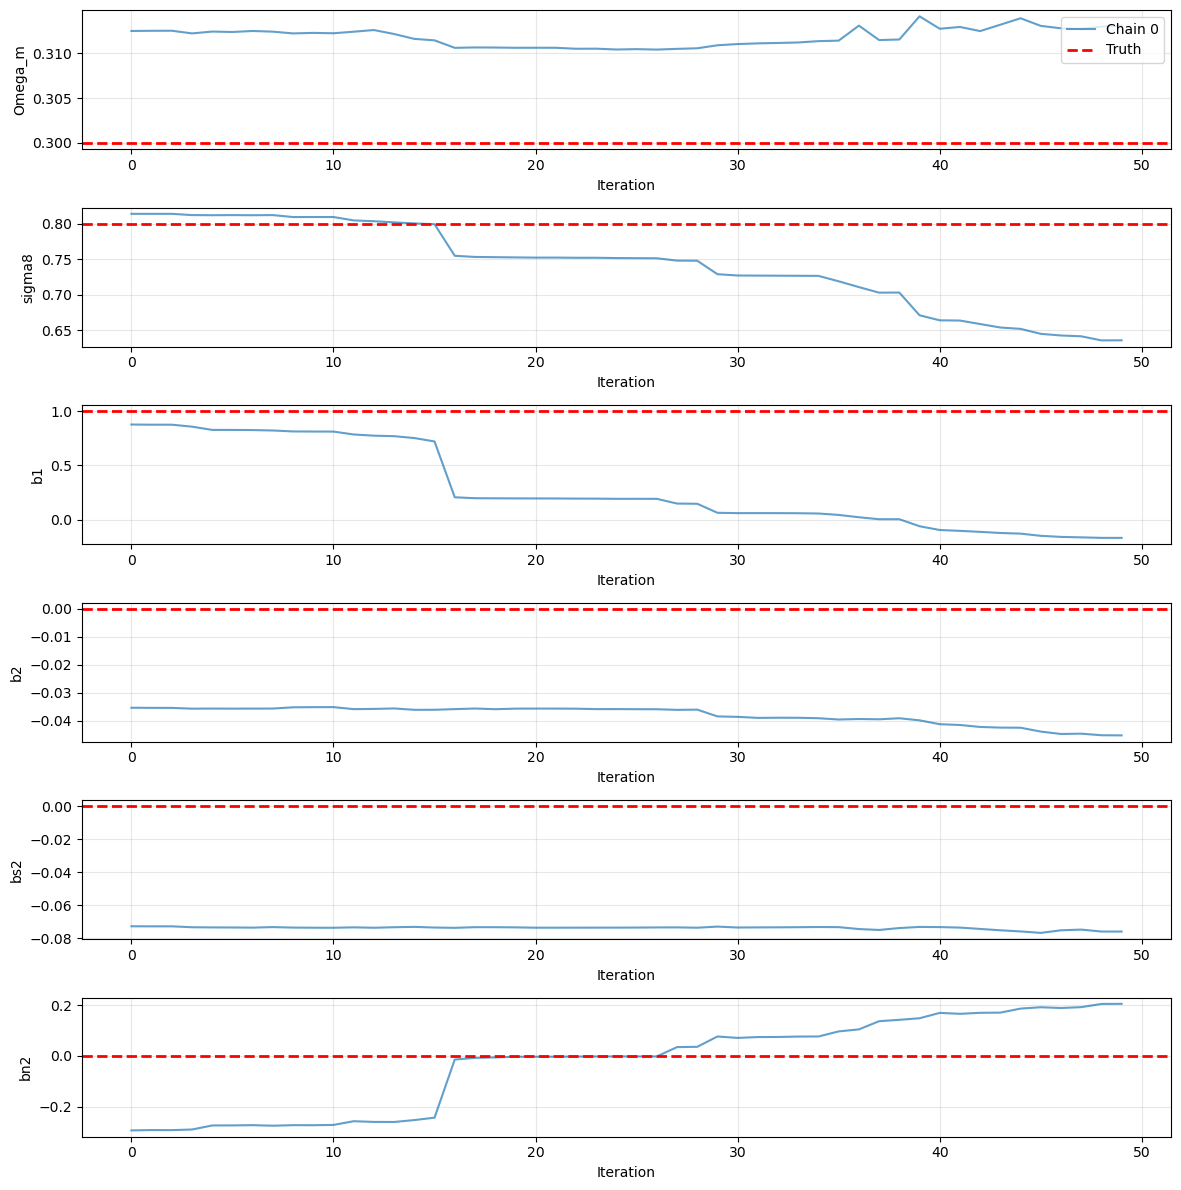

In [16]:
# Trace plots
fig, axes = plt.subplots(len(param_names), 1, figsize=(12, 2 * len(param_names)))

for i, param in enumerate(param_names):
    if param in samples:
        ax = axes[i]
        chain_data = samples[param]

        # Plot each chain
        for chain_idx in range(num_chains):
            ax.plot(chain_data[chain_idx, :], alpha=0.7, label=f"Chain {chain_idx}")

        # Truth line
        ax.axhline(truth_params[param], color="red", linestyle="--", linewidth=2, label="Truth")

        ax.set_ylabel(param)
        ax.set_xlabel("Iteration")
        if i == 0:
            ax.legend(loc="upper right")
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

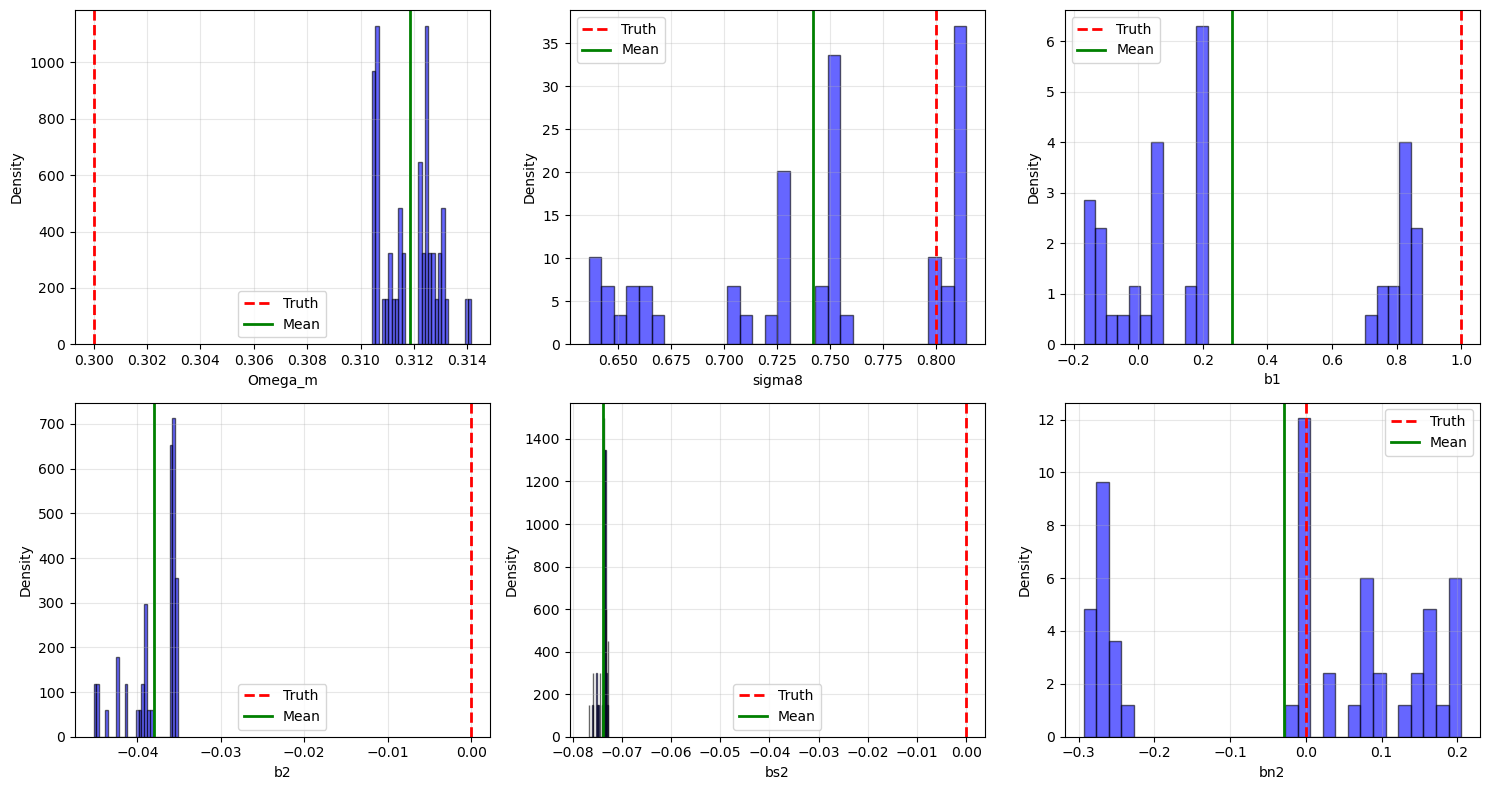

In [17]:
# Posterior distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, param in enumerate(param_names):
    if param in samples:
        ax = axes[i]
        chain_samples = samples[param].reshape(-1)

        # Histogram
        ax.hist(chain_samples, bins=30, density=True, alpha=0.6, color="blue", edgecolor="black")

        # Truth line
        ax.axvline(truth_params[param], color="red", linestyle="--", linewidth=2, label="Truth")

        # Mean line
        mean_val = np.mean(chain_samples)
        ax.axvline(mean_val, color="green", linestyle="-", linewidth=2, label="Mean")

        ax.set_xlabel(param)
        ax.set_ylabel("Density")
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Corner Plot

Show joint posterior distributions.

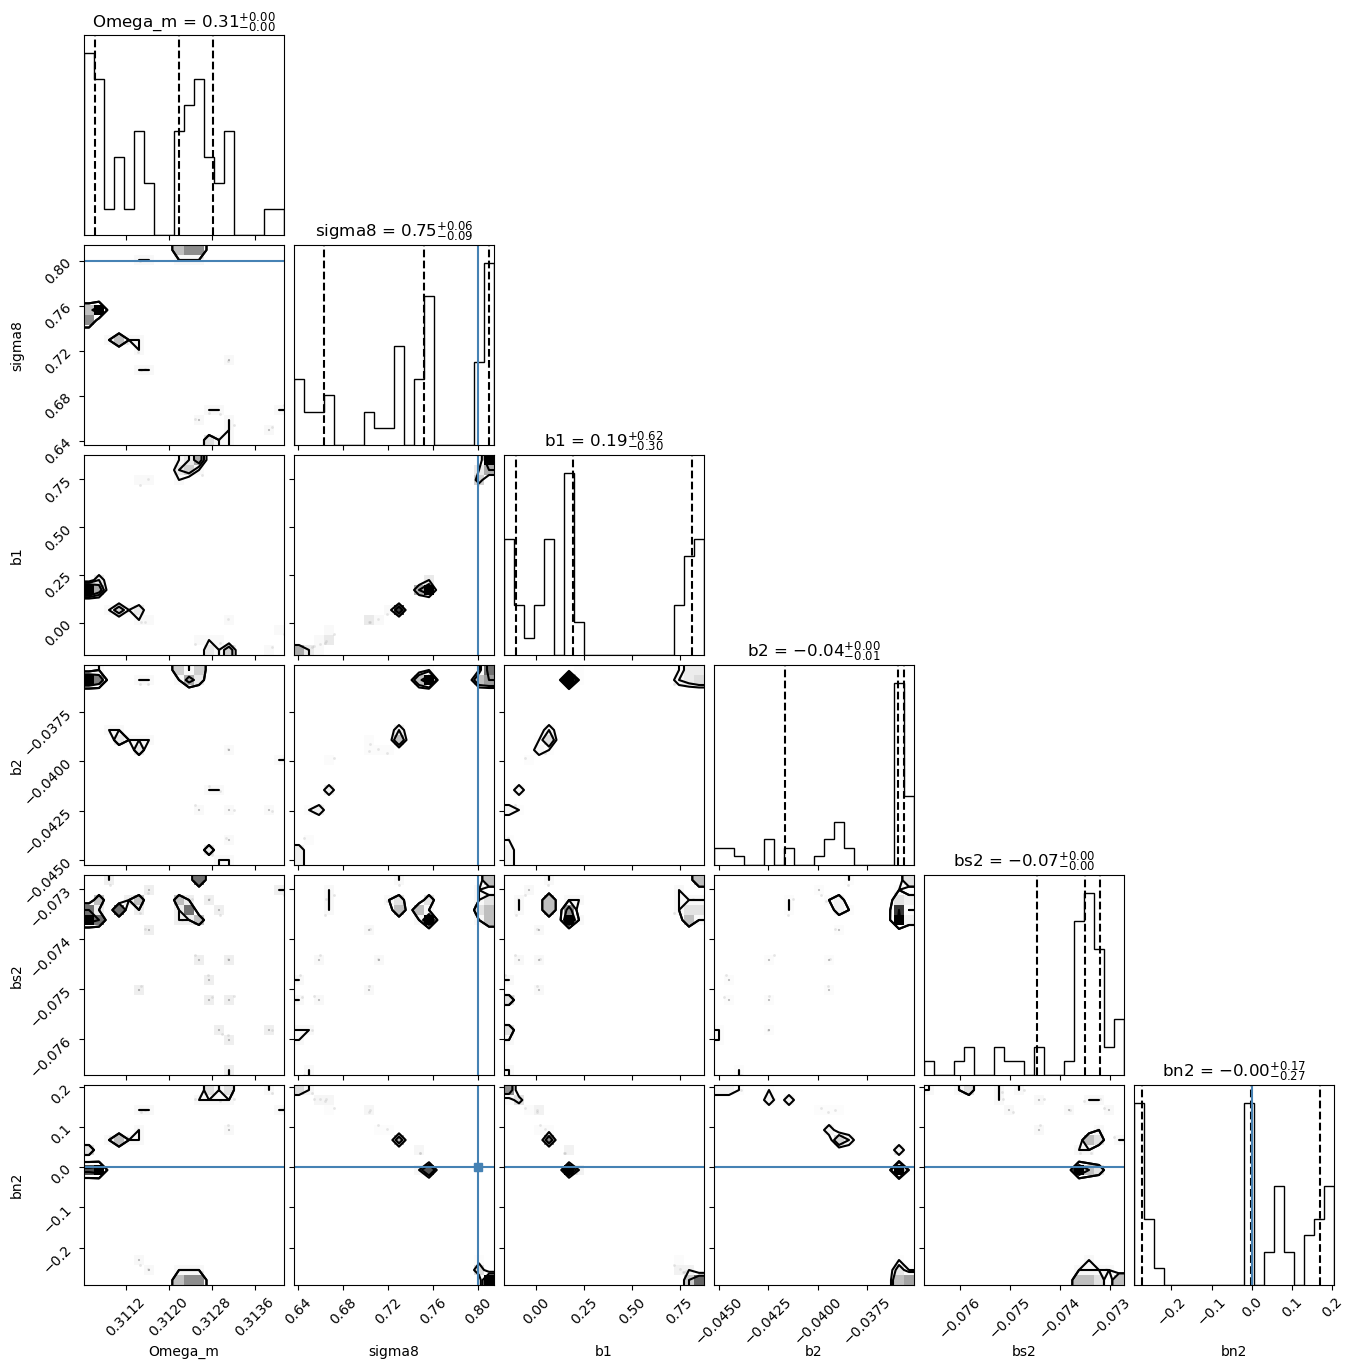

In [18]:
try:
    import corner

    # Prepare data for corner plot
    corner_data = np.column_stack([samples[p].reshape(-1) for p in param_names if p in samples])
    corner_labels = [p for p in param_names if p in samples]
    corner_truths = [truth_params[p] for p in corner_labels]

    fig = corner.corner(
        corner_data,
        labels=corner_labels,
        truths=corner_truths,
        quantiles=[0.16, 0.5, 0.84],
        show_titles=True,
        title_kwargs={"fontsize": 12},
    )
    plt.show()

except ImportError:
    print("Corner plot requires the 'corner' package. Install with: pip install corner")

## Summary

This notebook demonstrated:
- Creating a field-level model with specified configuration
- Generating synthetic observations from truth parameters
- Running MCMC inference with NUTS sampler
- Analyzing convergence and parameter recovery
- Visualizing chains and posteriors